In [1]:
# imports
import numpy as np
import pandas as pd
from collections import Counter
import math
import re
import networkx as nx
import csv

import matplotlib.pyplot as plt

We started by generating a sample of 50% of users from initial dataset.

In [4]:
df = pd.read_csv('../datasets/spotify_dataset.csv', 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')
                         
# keep only 50% of the data
spotify_df = df.sample(frac=0.01, random_state=0)
spotify_df.dropna(inplace=True)
spotify_df.sort_values(by=['user_id'], inplace=True)
spotify_df.reset_index(inplace=True, drop=True)
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,0007f3dd09c91198371454c608d47f22,Evanescence,My Immortal,Fav songs
1,0007f3dd09c91198371454c608d47f22,Plain White T's,Hey There Delilah,Fav songs
2,0007f3dd09c91198371454c608d47f22,Colourshop,2014,2014
3,000b0f32b5739f052b9d40fcc5c41079,Samuel Ljungblahd,I'm Sorry,Gospel
4,000c11a16c89aa4b14b328080f5954ee,Miles Davis,Stella By Starlight,Liked from Radio


One problem with the dataset is how the names of artists who collaborated on the same song are delimited. Since there is not a standard deminitation, we split the `artistiname` using multiple delimitators: "&", ",",  "/", "and", "feat.", "ft.", "featuring", "with" and check if it is a true collaboration and not the name of an artistic group.

In [5]:
spotify_df.drop_duplicates()

,user_id,artistname,trackname,playlistname
0,0007f3dd09c91198371454c608d47f22,Evanescence,My Immortal,Fav songs
1,0007f3dd09c91198371454c608d47f22,Plain White T's,Hey There Delilah,Fav songs
2,0007f3dd09c91198371454c608d47f22,Colourshop,2014,2014
3,000b0f32b5739f052b9d40fcc5c41079,Samuel Ljungblahd,I'm Sorry,Gospel
4,000c11a16c89aa4b14b328080f5954ee,Miles Davis,Stella By Starlight,Liked from Radio
...,...,...,...,...
128563,fff616055993498d6127f3f467cf9f2b,Fitz and The Tantrums,Out Of My League - TEPR Remix,bookstacks
128564,fff616055993498d6127f3f467cf9f2b,Sam Smith,Safe With Me,bookstacks
128565,fff77dadf8528083c920b9c018847e8b,Justin Timberlake,My Love,Liked from Radio
128566,fff77dadf8528083c920b9c018847e8b,Britney Spears,I'm a Slave 4 U,Liked from Radio


In [3]:
# generate initial artists set
artists_set = set(map(str.lower, spotify_df.artistname))

for idx, entry in spotify_df.iterrows():
    if (idx * 100 / len(spotify_df)) % 10 == 0:
        print(idx)
        
    is_group = True

    names = re.split('(?: and | & |, | \/ | feat. | ft. | f. | featuring | with |- )', str(entry.artistname.lower()))
    # check if artistname is not the name of an artistic group:
    if set(names).issubset(artists_set):
        # update the entry
        entry.artistname = names
    else:
        entry.artistname = [entry.artistname.lower()]


0
1285606


## Generate artists dataframe

In [5]:
# update the artists set
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])
len(artists_set)

140560

The resulted number of artists is too high to be processed, we have to extract the most relevant artists. Therefore, we computed a graph of collaborations and extracted the giant connected component.

### Extract artists

In [6]:
collaborations_graph = nx.Graph()
collaborations_graph.add_nodes_from(artists_set)

In [7]:
# add nodes if two artists have collaborated to the same song
for artists in spotify_df.artistname:
    for i in range(len(artists) - 1):
        for j in range(i+1, len(artists)):
            collaborations_graph.add_edge(artists[i], artists[j])

In [8]:
# extract the giant component
Gcc = sorted(nx.connected_components(collaborations_graph), key=len, reverse=True)
collaborations_graph = collaborations_graph.subgraph(Gcc[0])

In [9]:
# update the artists set
artists_set = set(collaborations_graph.nodes())
len(artists_set)

2905

Remove the entries with artists who are not found in `artists_set` from `spotify_df`

In [10]:
remove_idx = []
for idx, entry in spotify_df.iterrows():
    if not set(entry.artistname).issubset(artists_set):
        remove_idx.append(idx)

In [11]:
spotify_df.drop(remove_idx, axis=0, inplace=True)

### Compute artist populariy

In [12]:
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))
popularity.most_common(5)

[('daft punk', 7313),
 ('coldplay', 7238),
 ('the rolling stones', 6178),
 ('kanye west', 5928),
 ('eminem', 5884)]

In [13]:
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))
popularity.most_common()[-15: -1]

[('tuface idibia', 2),
 ('the ripper', 2),
 ('tony sunshine', 2),
 ('jean', 2),
 ('richard hayman', 2),
 ('dorsey', 2),
 ('yak', 2),
 ('baobinga', 2),
 ('id', 2),
 ('john dankworth', 2),
 ('shankar-jaikishan', 2),
 ('jacksons', 2),
 ('gary nesta pine', 2),
 ('akon -', 2)]

In [103]:
df.loc[df['artistname'].str.contains("- ", case=False, na=False)]

,user_id,artistname,trackname,playlistname
357,07f0fc3be95dcd878966b1f9572ff670,Daft Punk - Stardust,Human After All/Together/One More Time/Music S...,Daft Punk
1590,944c80d26922ae634d6ce445b1fdff7f,[500] Days Of Summer - Music From The Motion P...,A Story Of Boy Meets Girl,2014 beginning
1927,944c80d26922ae634d6ce445b1fdff7f,[500] Days Of Summer - Music From The Motion P...,A Story Of Boy Meets Girl,Starred
2138,944c80d26922ae634d6ce445b1fdff7f,Les Misérables - Original London Cast,Little People,Starred
9153,c50566d83fba17b20697039d5824db78,Various Artists - Azzurra Music,Sogno di un a notte di mezz'estate - Intermezzo,Everything at once
...,...,...,...,...
12875371,4a5b8338cbe3a8157b728dc8537fefbc,Various Artists - System Of A Down Tribute,Toxicity,System Of A Down
12876284,d10692996aa81d090bfbcf97a82e98b7,Diddy - Dirty Money & Skylar Grey,Coming Home (feat. Skylar Grey),Iphone music
12876514,d10692996aa81d090bfbcf97a82e98b7,Diddy - Dirty Money & Skylar Grey,Coming Home (feat. Skylar Grey),Marathon Music Son
12879445,a0e3321d33fb3c9d0a4d822978cf8882,Daddy's Groove - David Guetta,In My Head (feat. Nervo),David Guetta - Nothing But the Beat Ultimate


Save `artists_set` as csv file

In [165]:
with open('artists.csv', 'w') as f:      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(artists_set)

## User dataframe

In [14]:
users_dict = dict((k, list()) for k in set(spotify_df.user_id))

for _, entry in spotify_df.iterrows():
    if (entry.trackname, entry.artistname) not in users_dict[entry.user_id]:
        users_dict[entry.user_id].append((entry.trackname, entry.artistname))


In [ ]:
len(users_dict)

In [190]:
# Users number of songs
users_tracks_no=Counter({k: len(v) for k, v in users_dict.items()})

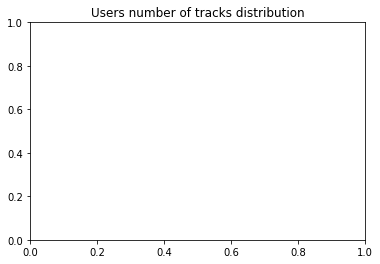

In [197]:
# Users track number distribution
plt.title('Users number of tracks distribution')
plt.figure(figsize=(15,5))
plt.bar(users_tracks_no.keys(), users_tracks_no.values())
plt.xlabel("Number of tracks")
plt.ylabel("Frequency")

plt.show()

In [176]:
len(users_dict)

7826

In [177]:
# remove user with less that 30 tracks
users_dict = {k: v for k, v in users_dict.items() if len(v) > 30}

In [183]:
a=Counter({k: len(v) for k, v in users_dict.items()})

Extract the most relevant users by computing the giant connecting componet

In [184]:
a.most_common(5)

[('fa849dabeb14a2800ad5130907fc5018', 7462),
 ('7ee2b92c5bcf6133b8132363e5bda960', 5953),
 ('4398de6902abde3351347b048fcdc287', 5745),
 ('6b85a8076b4f3b1036ef15f09e2feeeb', 4086),
 ('99deafd9b792af8e6a535483088faef2', 3739)]

### Extract users

In [178]:
users_graph = nx.Graph()
users_graph.add_nodes_from(list(users_dict.keys()))

In [179]:
users_set = list(users_dict.keys())

In [182]:
users_no = len(users_set)

for i in range(users_no - 1):
    if i % 100 == 0:
        print(i)
    for j in range(i, users_no):
        user_A = users_set[i]
        user_B = users_set[j]

        for track_A in users_dict[user_A]:
            if track_A in users_dict[user_B]:
                users_graph.add_edge(user_A, user_B)
                break

0


KeyboardInterrupt: 

In [144]:
users_no

14865